# Genrate Data bases for the project

## Support Calculations

In [3]:
def CalculeSup(db,items):
  items=list(items)
  l=len(items)
  Sup=0
  for i in range(db["D"]): #db["DB"][item]:
    b=True
    j=0
    while b and j < l:
      b = b and db["DB"][items[j]][i]==1
      j+=1
    Sup+=1 if b else 0
  Sup=Sup/db["D"]
  return Sup

## Create a function that randomly create a set of data to treate in a shape of a matrix N*M 
  - nDBs number of DataBases to create
  - nItems is the number of Items for all the database
  - min-max transactions : is the number of transactions (N is not constant for all DBs)
  - function return a dictionary that contain DBs and the |DBs|

In [2]:
import numpy as np
import pandas as pd
import random
def CreateDbs(nDBs,nItems,minTransactions=10,maxTransactions=15):
  DBs={
      "DBs":[],
      "D":0, # nmbr of transaction global
      "CL": [ chr(x) for x in range(97,nItems+97)] #Column list
  }
  for i in range(nDBs):
    l=random.randint(minTransactions, maxTransactions) # nmbr of  transaction local
    db= np.random.randint(0,2,size=(l, nItems),dtype =np.uint8) # data base local
    DB={"DB": pd.DataFrame( db,columns=DBs["CL"]) ,"D":l}# transform data base from matrix into data frame
    supports=[]
    for clm in DBs["CL"]:
      supports.append(CalculeSup( DB,clm))
    DB["DB"].loc["SUP"]=supports
    DBs["DBs"].append(DB)
    DBs["D"]+=l
  return DBs

# Create The data Bases using the function CreateDBs

In [3]:
DataBases = CreateDbs(10,5)
#Test 
DB={
    "DB":pd.DataFrame([
                        [1,1,1,1,1],
                        [1,1,0,0,0],
                        [0,0,1,0,1],
                        [1,1,0,1,1],
                        [1,0,1,1,0]
                        ],columns=DataBases["CL"]),
  "D":5
}
supports=[]
for clm in DataBases["CL"]:
  supports.append(CalculeSup( DB,clm))
DB["DB"].loc["SUP"]=supports
print(DB,DataBases)

{'DB':        a    b    c    d    e
0    1.0  1.0  1.0  1.0  1.0
1    1.0  1.0  0.0  0.0  0.0
2    0.0  0.0  1.0  0.0  1.0
3    1.0  1.0  0.0  1.0  1.0
4    1.0  0.0  1.0  1.0  0.0
SUP  0.8  0.6  0.6  0.6  0.6, 'D': 5} {'DBs': [{'DB':        a    b    c    d    e
0    1.0  0.0  1.0  0.0  0.0
1    1.0  1.0  1.0  1.0  1.0
2    1.0  0.0  1.0  0.0  1.0
3    1.0  1.0  1.0  0.0  0.0
4    1.0  0.0  1.0  1.0  0.0
5    0.0  1.0  1.0  1.0  1.0
6    1.0  0.0  1.0  0.0  1.0
7    1.0  0.0  1.0  1.0  0.0
8    0.0  1.0  0.0  0.0  0.0
9    0.0  0.0  0.0  1.0  0.0
SUP  0.7  0.4  0.8  0.5  0.4, 'D': 10}, {'DB':             a    b         c         d         e
0    0.000000  1.0  1.000000  1.000000  0.000000
1    0.000000  0.0  0.000000  0.000000  0.000000
2    0.000000  0.0  0.000000  1.000000  1.000000
3    0.000000  0.0  0.000000  0.000000  0.000000
4    1.000000  1.0  0.000000  1.000000  1.000000
5    1.000000  1.0  0.000000  0.000000  1.000000
6    0.000000  1.0  0.000000  1.000000  1.000000
7    0.

# Add intersection Column

In [4]:
def Intersection(db,clmn):
  clmns=list(clmn)
  elms=[]
  supports=0
  for i in range(db["D"]):
    b=True
    j=0
    while b and j < len(clmns): 
      if db["DB"][clmns[j]][i]!=1 :
        b=False
      j+=1
    x=1 if b else 0
    supports+=x
    elms.append(x)
  elms.append(supports/db["D"])
  db["DB"][clmn]=elms

# Association Rules

In [5]:
class AssociationRule:
  def __init__(self,a,b):
    self.antecedent =set(a)
    self.antecedentS="".join(sorted(self.antecedent))
    self.consequent =set(b) - self.antecedent
    self.consequentS="".join(sorted(self.consequent))
    self.g="".join(sorted(self.antecedent.union(self.consequent) ))
  def add(self,b):
    b=set(b)-self.antecedent
    if len(b)>0 :
      self.consequent|=b
      self.consequentS="".join(sorted(self.consequent))
      self.g="".join(sorted(self.antecedent.union(self.consequent) ))
  def __str__(self):
    return self.g+" : "+self.antecedentS+"->"+self.consequentS
class AssociationRules:
  def __init__(self):
    self.list=[]
  def __str__(self):
    return str([ str(x) for x in self.list ])
  def append(self,antecedent,consequent):
    for x in self.list:
      if x.antecedentS==antecedent:
        x.add(consequent)
        return
    self.list.append(AssociationRule(antecedent,consequent))
  def In(self,a):
    for x in self.list:
      if x.g==a :
        return True
    return False

# Close Algorithm

## Check if item is close to another

In [6]:
def isClose(db,a,b):
  A=db["DB"][a]
  B=db["DB"][b]
  b=True
  i=0
  for i in range(db["D"]):
    if A[i]==1 :
      if B[i]!=1 :
        return False
  return True

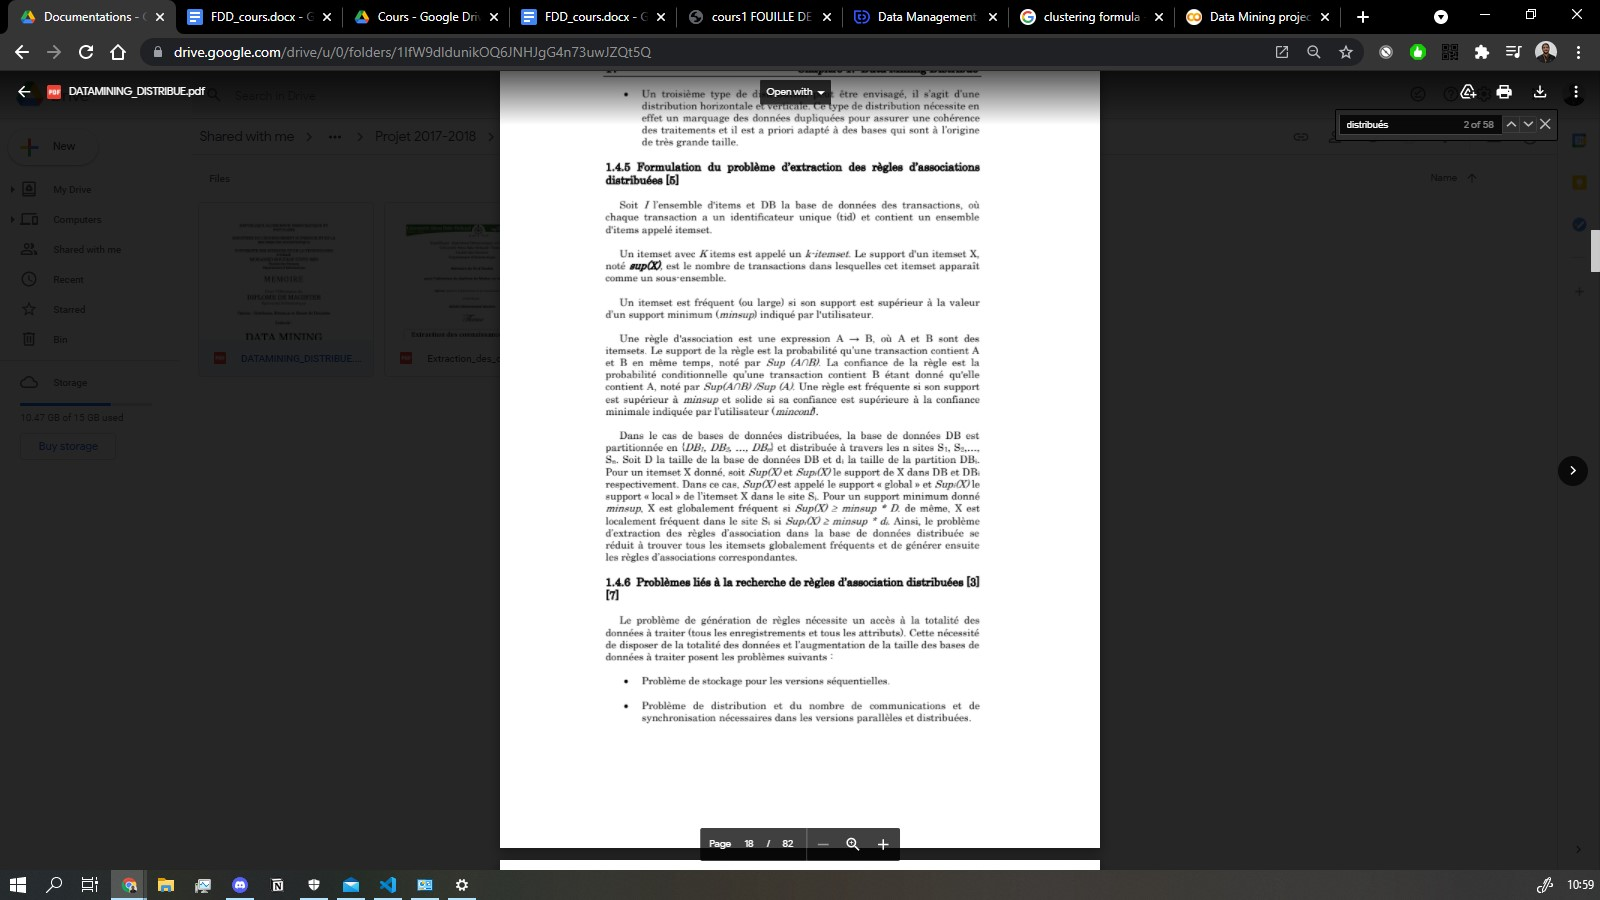

## Close all items of a data base

In [7]:
def CloseItems(db,clmns,minSup=0.4):
  temp=db["DB"]
  db["DB"]=  temp.copy()
  # initialisation of Items
  ItemsSet= [i for i in clmns ]
  Eliminated=set()
  associationRules=AssociationRules()
  while ItemsSet :
    print("ItemsSet",ItemsSet)
    print(db["DB"])
    item=0
    while item<len(ItemsSet):
      # Prune the set of candidates against "minSup"
      if db["DB"][ItemsSet[item]]["SUP"] < minSup:
        Eliminated.add(ItemsSet.pop(item))
      else:
        item+=1
    newItems=set()
    # calculate the closures of successful candidates
    
    for i in range(len(ItemsSet)):
      for j in clmns:
        if "".join(sorted({*list(ItemsSet[i]),j}))!=ItemsSet[i]:
          if isClose(db,ItemsSet[i],j):
            associationRules.append( ItemsSet[i],j )
          else : 
            # filter Eliminated candidates
            nItem="".join( sorted( set(ItemsSet[i]).union(j) ) )
            b=True
            for x in Eliminated:
              if x in nItem:
                b=False
                break
            #  Build the set of candidates for the next iteration
            if b : 
              newItems.add( nItem )
    
    ItemsSet=[]
    print("AssociationRules",associationRules)
    for nItem in sorted(newItems):
      if not associationRules.In(nItem) :
        ItemsSet.append(nItem)
        # Calculate the support of the candidates
        Intersection(db,nItem)
    print("Eliminated : "+ str(Eliminated))
  

CloseItems(DB,DataBases["CL"])

ItemsSet ['a', 'b', 'c', 'd', 'e']
       a    b    c    d    e
0    1.0  1.0  1.0  1.0  1.0
1    1.0  1.0  0.0  0.0  0.0
2    0.0  0.0  1.0  0.0  1.0
3    1.0  1.0  0.0  1.0  1.0
4    1.0  0.0  1.0  1.0  0.0
SUP  0.8  0.6  0.6  0.6  0.6
AssociationRules ['ab : b->a', 'ad : d->a']
Eliminated : set()
ItemsSet ['ac', 'ae', 'bc', 'bd', 'be', 'cd', 'ce', 'de']
       a    b    c    d    e   ac   ae   bc   bd   be   cd   ce   de
0    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
1    1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2    0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
3    1.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0
4    1.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
SUP  0.8  0.6  0.6  0.6  0.6  0.4  0.4  0.2  0.4  0.4  0.4  0.4  0.4
AssociationRules ['ab : b->a', 'ad : d->a', 'acd : ac->d', 'abde : ae->bd', 'abde : bd->ae', 'abde : be->ad', 'acd : cd->a', 'abde : de->ab']
Eliminated : {'b